In [1]:
import numpy as np
import random as rnd
import openpyxl as opx
from scipy.stats import norm, wasserstein_distance, chisquare
import matplotlib.pyplot as plt
import time

In [2]:
def gaussian_distribution(days_distribution):
    # Parámetros de la campana de Gauss deseada
    mean = days_distribution / 2
    std_dev = 8.8

    # Crear un rango de valores en el eje x
    x_values = np.linspace(1, days_distribution, days_distribution)
    y_values = norm.pdf(x_values, mean, std_dev)

    # Ajustar la campana de Gauss para que la suma de las probabilidades sea 1
    sum_y_values = np.sum(y_values)
    ajuste = (1 - sum_y_values) / days_distribution

    for i in range(len(y_values)):
        y_values[i] += ajuste

    #print("Distribución Objetivo:\n", y_values)
    #suma = np.sum(y_values)
    #print("Suma:", suma)

    return y_values, x_values

In [ ]:
#Para crear grafica de la distribucion de probabilidad
work_days = 44
target_distribution, x_values = gaussian_distribution(work_days)

target_distribution = target_distribution * 1000

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))
plt.plot(target_distribution, label='Valor planeado')
plt.title('Actividad de 44 días')
plt.xlabel('Días laborables')
plt.ylabel('Recursos')
plt.legend()
plt.show()

In [ ]:
# Simulamos un avance real de la tarea que representa un atraso del 20%
real_progress = np.array([target_distribution[i] * 0.9 if i < 10 else None for i in range(work_days)])

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y)))
plt.plot(target_distribution, label='Valor planeado')
plt.plot(real_progress, label='Valor ganado')
plt.title('Actividad de 44 días')
plt.xlabel('Días laborables')
plt.ylabel('Recursos')
plt.legend()
plt.show()

In [3]:
# Función de inicialización de la población
def initialize_population(population_size, genome_size, remainder):
    # Crear un arreglo con valores entre 0 y 0.5
    population = [np.random.uniform(0, 0.5, genome_size) for _ in range(population_size)]

    # Ajustar algunos valores para que la suma sea igual al remanente
    for i in range(population_size):
        population[i] = population[i] / np.sum(population[i]) * remainder

    #print(np.array(population))
    #print("Suma de cada fila:", np.sum(population, axis=1))
    return np.array(population)


In [4]:
def mse_fitness(y_true, y_pred):
  # Calcula la diferencia entre los valores reales y predichos
  error = y_true - y_pred

  # Calcula el cuadrado del error
  squared_error = np.square(error)

  # Calcula la media del cuadrado del error
  mse = (1 / (1 + np.mean(squared_error)))
  return mse

In [ ]:
# Función de aptitud basada en la métrica de Wasserstein
def wasserstein_fitness(individual, target_distribution):
    return 1 / (1 + wasserstein_distance(individual, target_distribution))

In [ ]:
def chisquare_fitness(individual, target_distribution):
    target_distribution = target_distribution / np.sum(target_distribution)
    individual = individual / np.sum(individual)

    return 1 / (1 + chisquare(individual, target_distribution)[0])

In [5]:
# Cruce de un individuos 
def one_point_crossover(parent1, parent2, crossover_rate):
    if np.random.rand() < crossover_rate:
        crossover_point = np.random.randint(1, len(parent1) - 1)
        #print("Punto de cruce:", crossover_point)
        child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
        return child1, child2
    else:
        return parent1, parent2

In [ ]:
def two_point_crossover(parent1, parent2, crossover_rate):
    if np.random.rand() < crossover_rate:
        # Seleccionar dos puntos de cruce aleatoriamente
        point1 = np.random.randint(1, len(parent1) - 1)
        point2 = np.random.randint(point1, len(parent1) - 1)
        
        # Crear los hijos intercambiando los segmentos entre los dos puntos de cruce
        child1 = np.concatenate((parent1[:point1], parent2[point1:point2], parent1[point2:]))
        child2 = np.concatenate((parent2[:point1], parent1[point1:point2], parent2[point2:]))
        
        return child1, child2
    else:
        return parent1, parent2

In [6]:
# Mutación de un individuo
def mutate(individual, mutation_rate):
    mask = np.random.rand(len(individual)) < mutation_rate
    individual[mask] = np.random.rand(sum(mask))
    return individual

In [7]:
# Algoritmo genético
def genetic_algorithm_test(target_distribution, real_progress, population_size=50, generations=50, crossover_rate=0.8, mutation_rate=0.1):
    progress_days = sum(1 for value in real_progress if value is not None)
    genome_size = len(target_distribution) - progress_days
    # Eliminamos los días que ya han pasado
    target_dist_to_end = target_distribution[progress_days:]
    
    # Inicializar la población arreglos que suman el remanente para terminar las tareas
    remainder = 1 - sum(value for value in real_progress if value is not None)
    population = initialize_population(population_size, genome_size, remainder)
    evolution = []

    for generation in range(generations):
        # Calcular la aptitud de cada individuo en la población
        fitness_values = np.array([mse_fitness(individual, target_dist_to_end) for individual in population])
        #fitness_values = np.array([chisquare_fitness(individual, target_dist_to_end) for individual in population])

        # Seleccionar los dos mejores individuos
        #selected_indices = np.argsort(fitness_values)[-2:]
        #parents = population[selected_indices]

        selected_indices = rnd.sample(range(len(fitness_values)), 4)
        if fitness_values[selected_indices[0]] > fitness_values[selected_indices[1]]:
            index1 = selected_indices[0]
        else:
            index1 = selected_indices[1]

        if fitness_values[selected_indices[2]] > fitness_values[selected_indices[3]]:
            index2 = selected_indices[2]
        else:
            index2 = selected_indices[3]

        indx = [index1, index2]
        parents = population[indx]
        #print("Padres:", parents)   

        # Cruzar y mutar para obtener nuevos individuos
        children = [mutate(child, mutation_rate) for child in one_point_crossover(*parents, crossover_rate)]
        #print("Hijos:", children)

        # Reemplazar los dos peores individuos en la población con los nuevos individuos
        worst_indices = np.argsort(fitness_values)[:2]
        population[worst_indices] = children

        # Imprimir la aptitud del mejor individuo en esta generación
        best_fitness = np.max(fitness_values)
        evolution.append({"Generación": generation + 1, "Mejor Aptitud": best_fitness})
        #print("Generación:", generation + 1, "Mejor Aptitud", best_fitness)

    # Devolver el mejor individuo al final del algoritmo
    best_index = np.argmax(fitness_values)
    best_individual = population[best_index]

    data_convergence = [{"Best Fitness": best_fitness, "Generations": generations, "Population": population_size, "Crossover Rate": crossover_rate, "Mutation_Rate": mutation_rate}]
    
    return best_individual, data_convergence, evolution

In [8]:
# Algoritmo genético
def genetic_algorithm(target_distribution, real_progress, population_size=50, crossover_rate=0.8, mutation_rate=0.1):
    progress_days = sum(1 for value in real_progress if value is not None)
    genome_size = len(target_distribution) - progress_days
    # Eliminamos los días que ya han pasado
    target_dist_to_end = target_distribution[progress_days:]
    
    # Inicializar la población arreglos que suman el remanente para terminar las tareas
    remainder = 1 - sum(value for value in real_progress if value is not None)
    population = initialize_population(population_size, genome_size, remainder)
    evolution = []

    generations = 0

    for generation in range(21):
        # Calcular la aptitud de cada individuo en la población
        fitness_values = np.array([mse_fitness(individual, target_dist_to_end) for individual in population])
        #fitness_values = np.array([chisquare_fitness(individual, target_dist_to_end) for individual in population])

        # Seleccionar los dos mejores individuos
        #selected_indices = np.argsort(fitness_values)[-2:]
        #parents = population[selected_indices]

        selected_indices = rnd.sample(range(len(fitness_values)), 4)
        if fitness_values[selected_indices[0]] > fitness_values[selected_indices[1]]:
            index1 = selected_indices[0]
        else:
            index1 = selected_indices[1]

        if fitness_values[selected_indices[2]] > fitness_values[selected_indices[3]]:
            index2 = selected_indices[2]
        else:
            index2 = selected_indices[3]

        indx = [index1, index2]
        parents = population[indx]
        #print("Padres:", parents)   

        # Cruzar y mutación para obtener nuevos individuos
        children = [mutate(child, mutation_rate) for child in one_point_crossover(*parents, crossover_rate)]
        #print("Hijos:", children)

        # Reemplazar los dos peores individuos en la población con los nuevos individuos
        worst_indices = np.argsort(fitness_values)[:2]
        population[worst_indices] = children

        # Imprimir la aptitud del mejor individuo en esta generación
        best_fitness = np.max(fitness_values)
        evolution.append({"Generación": generation + 1, "Mejor Aptitud": best_fitness})
        
        generations = generation + 1
        
        if best_fitness >= 0.999917785:
            break;
        #print("Generación:", generation + 1, "Mejor Aptitud", best_fitness)

    # Devolver el mejor individuo al final del algoritmo
    best_index = np.argmax(fitness_values)
    best_individual = population[best_index]

    data_convergence = [{"Best Fitness": best_fitness, "Generations": generations, "Population": population_size, "Crossover Rate": crossover_rate, "Mutation_Rate": mutation_rate}]
    
    return best_individual, data_convergence, evolution

In [ ]:
# Crear un libro de trabajo en blanco
wb = opx.Workbook()

# Agregar una hoja (por defecto ya hay una hoja activa)
hoja_activa = wb.active
hoja_activa.title = "General"  # Cambia el nombre de la hoja si lo deseas

#Ejecucipon de la tarea
work_days = 44
pruebas = 21
# Se crea una simulación de la distribución de probabilidad de la campana de Gauss para una tarea planificada.
target_distribution, x_values = gaussian_distribution(work_days)

# Simulamos un avance real de la tarea que representa un atraso del 20%
real_progress = np.array([target_distribution[i] * 0.8 if i < 10 else None for i in range(work_days)])

hoja_activa['A1'] = "Test"
hoja_activa['B1'] = "Best Fitness"
hoja_activa['C1'] = "Generations"
hoja_activa['D1'] = "Population"
hoja_activa['E1'] = "Crossover Rate"
hoja_activa['F1'] = "Mutation Rate"
hoja_activa['G1'] = "Time"

# Ejecutar el algoritmo genético
for i in range(pruebas):
    #Números aleatorios para generaciones de 100 a 1000
    gen = rnd.randint(100, 1000)
    #Números aleatorios para la población de 100 a 1000
    pop = rnd.randint(100, 1000)
    #Números aleatorios para cruce de 0.8 al 0.95
    cru = round(rnd.uniform(0.6, 0.95), 4)
    #Números aleatorios para mutación de 0.01 a 0.1
    mut = round(rnd.uniform(0.01, 0.2), 4)

    #pop = 231
    #cru = 0.8463
    #mut = 0.0131

    inicio = time.time()
    #Ejecutar el test para obtener los parámetros del algoritmo genético
    best_solution, data_convergence, evolution = genetic_algorithm_test(target_distribution, real_progress, population_size=pop, generations=gen, crossover_rate=cru, mutation_rate=mut)
    #Ejecutar el algoritmo genético con los paramatros obtenidos del test
    #best_solution, data_convergence, evolution = genetic_algorithm(target_distribution, real_progress, population_size=pop, crossover_rate=cru, mutation_rate=mut)
    fin = time.time()
    tiempo_ejecucion = fin - inicio
    hoja_activa.append([str(i + 1), data_convergence[0]["Best Fitness"], data_convergence[0]["Generations"], data_convergence[0]["Population"], data_convergence[0]["Crossover Rate"], 
                        data_convergence[0]["Mutation_Rate"], round(tiempo_ejecucion, 4)])
    # Medición del tiempo de ejecución
    
    evolution_sheet = wb.create_sheet("Test" + str(i + 1))
    evolution_sheet.append(["Generación", "Mejor Aptitud T" + str(i + 1)])

    for e in evolution:
        evolution_sheet.append([e["Generación"], e["Mejor Aptitud"]])
    
    print(f"Test {i + 1} - Best Fitness: {data_convergence[0]['Best Fitness']}, Generations: {data_convergence[0]['Generations']}, Population: {data_convergence[0]['Population']}, Crossover Rate: {data_convergence[0]['Crossover Rate']}, Mutation Rate: {data_convergence[0]['Mutation_Rate']}, Time: {round(tiempo_ejecucion, 4)}")

wb.save(f"AGTest.xlsx")


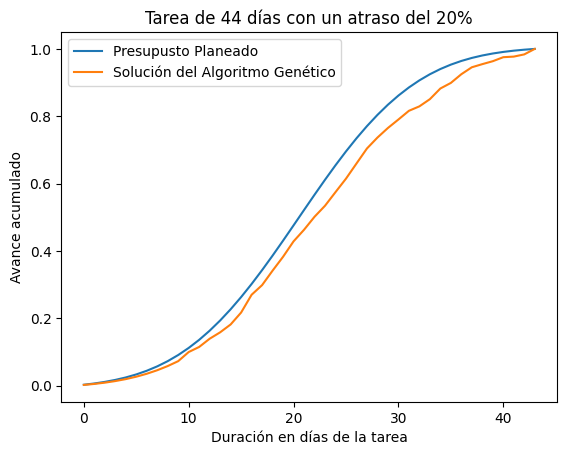

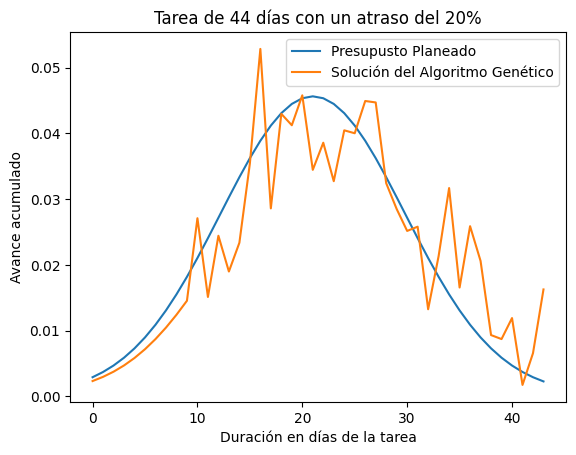

Distribución Objetivo: [0.29 0.37 0.47 0.59 0.73 0.9  1.09 1.31 1.55 1.82 2.1  2.41 2.72 3.03
 3.33 3.62 3.89 4.12 4.31 4.45 4.53 4.56 4.53 4.45 4.31 4.12 3.89 3.62
 3.33 3.03 2.72 2.41 2.1  1.82 1.55 1.31 1.09 0.9  0.73 0.59 0.47 0.37
 0.29 0.23]
Suma de la distribución objetivo: 1.0
Avance Real: [0.23 0.3  0.38 0.47 0.58 0.72 0.87 1.05 1.24 1.45  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan]
Solución: [0.23 0.3  0.38 0.47 0.58 0.72 0.87 1.05 1.24 1.45 2.71 1.51 2.44 1.9
 2.34 3.54 5.28 2.86 4.3  4.12 4.58 3.44 3.86 3.27 4.04 4.   4.49 4.47
 3.24 2.85 2.52 2.58 1.32 2.13 3.17 1.66 2.59 2.06 0.93 0.87 1.19 0.17
 0.66 1.63]
Suma de la solución: 0.9999999999999998
Convergencia: [{'Best Fitness': 0.9999304939854564, 'Generations': 500, 'Population': 48, 'Crossover Rate': 0.7317, 'Mutation_Rate': 0.0269}]


In [9]:

#Ejecucipon de la tarea
work_days = 44
# Se crea una simulación de la distribución de probabilidad de la campana de Gauss para una tarea planificada.
target_distribution, x_values = gaussian_distribution(work_days)

# Simulamos un avance real de la tarea que representa un atraso del 20%
real_progress = np.array([target_distribution[i] * 0.8 if i < 10 else None for i in range(work_days)])

# Ejecutar el algoritmo genético
best_solution, data_convergence, evolution = genetic_algorithm_test(target_distribution, real_progress, generations=500, population_size=48, crossover_rate=0.7317, mutation_rate=0.0269)
remainder = 1 - sum(value for value in real_progress if value is not None)
best_solution = best_solution / np.sum(best_solution) * remainder
#print("Mejor Solución:", best_solution)

real = real_progress[real_progress != None]
solution = np.concatenate((real, best_solution))

cumsum_tarjet_dist = np.cumsum(target_distribution)
cumsum_solution = np.cumsum(solution)
sum_tarjet_dist = np.sum(target_distribution)
sum_solution = np.sum(solution)

# Graficar la campana de Gauss
#plt.plot(x_values, target_distribution, label='Campana de Gauss')
#plt.plot(x_values, real_progress, label='Campana de Gauss al 80%')
#plt.plot(x_values, solution, label='Solución')
plt.plot(cumsum_tarjet_dist, label='Presupusto Planeado')
plt.plot(cumsum_solution, label='Solución del Algoritmo Genético')
plt.title('Tarea de 44 días con un atraso del 20%')
plt.xlabel('Duración en días de la tarea')
plt.ylabel('Avance acumulado')
plt.legend()
plt.show()

plt.plot(target_distribution, label='Presupusto Planeado')
plt.plot(solution, label='Solución del Algoritmo Genético')
plt.title('Tarea de 44 días con un atraso del 20%')
plt.xlabel('Duración en días de la tarea')
plt.ylabel('Avance acumulado')
plt.legend()
plt.show()

target_distribution = target_distribution.astype(float)
target_distribution = np.round(target_distribution * 100, 2)
print("Distribución Objetivo:", target_distribution)
print("Suma de la distribución objetivo:", sum_tarjet_dist)

real_progress = real_progress.astype(float)
real_progress = np.round(real_progress * 100, 2)
print("Avance Real:", real_progress)

solution = solution.astype(float)
solution = np.round(solution * 100, 2)
print("Solución:", solution)
print("Suma de la solución:", sum_solution)

print("Convergencia:", data_convergence)

